# Graph Classification

Here we want to embed entire graphs, and we want to embed those graphs in such a way so that they are linearly separable for given number of classes.

One common task in graph classification domain is **molecular property prediction**, in which molecules are represented as graphs: atoms -> nodes, bonds -> edges, and the task may be to infer whether a molecule(graph) is toxic or not.

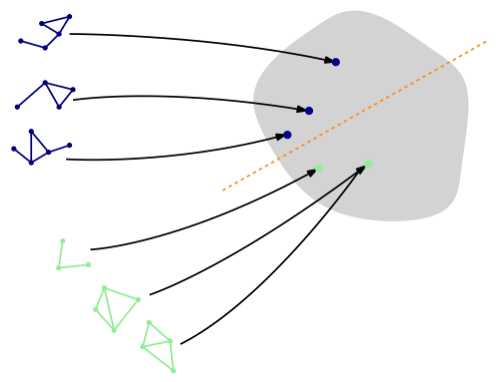

# Installing Required Libraries
Please install the following libraries

In [1]:
# # Install required packages.
# import os
# import torch
# os.environ['TORCH'] = torch.__version__
# print(torch.__version__)
#
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !pip install plotly
# !pip install tqdm

# Importing Libraries

In [38]:
# torch and pytorch geometric
import torch
import torch.nn.functional as F
from torch.nn import Linear, Parameter
from torch.nn.init import xavier_uniform_, zeros_
from torch_geometric.nn import MessagePassing, GCNConv, GATv2Conv, GINConv, global_mean_pool
from torch_geometric.utils import add_self_loops, remove_self_loops, degree, softmax
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

# General purpose
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# For visualization
import matplotlib.pyplot as plt
import plotly.express as px
import tqdm

# Custom
# from Files import utils
from Libs.utils import seed_everything, create_early_stopper
seed_everything()

# Dataset

The TU Dortmund University has collected a wide range of different graph classification datasets, know as the [**TUDatasets**](https://chrsmrrs.github.io/datasets/), which are also accessible via [`torch_geometric.datasets.TUDataset`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.TUDataset) in PyTorch Geometric.
Here the dataset which is a smaller one that has some edge features, the **MUTAG dataset**:

In [2]:
os.makedirs('./data', exist_ok=True)

dataset = TUDataset(root='./data', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of edge features: {dataset.num_edge_features}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2
Number of edge features: 4

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


The dataset has 188 different graphs, and the task is to classify each graph into one out of two classes.

- 7-dimensional feature vectors for node features
- one graph label
- 4-dimensional edge features

In [18]:
torch.manual_seed(42)
dataset = dataset.shuffle()

# train_dataset = dataset[:150]
# test_dataset = dataset[150:]
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.25, random_state=42)

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 112
Number of validation graphs: 38
Number of test graphs: 38


# Mini-Batching of Graphs

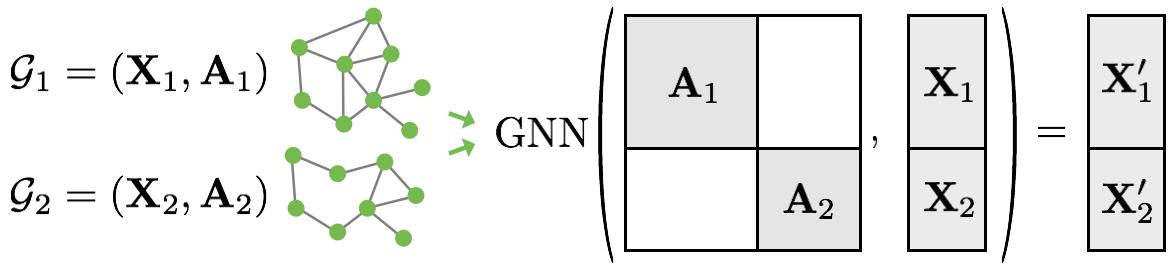

Since graphs in graph-classification datasets are usually small, we can use mini-batches of graphs for feeding the GNN.

The way mini-batch is working on graph-classification / regression tasks is the following.
- Adjacency matrices of graphs are stacked in a diagonal way.
- This will create a giant graph that holds multiple isolated sub-graphs
- So nodes and target features are concatenated in the node dimension.(Same goes for edge features)

Advantages of this approach
01. GNN operates on a message passing scheme, so it does not need to be modified since messages are not exchanged between two nodes that belong to different graphs
02. There is no computational or memory overhead following this approach as all adjacency matrices are saved in a sparse fashion(COO format) holding only non-zero entries: i.e, the edges

In [19]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# On the training dataset
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2490], x=[1137, 7], edge_attr=[2490, 4], y=[64], batch=[1137], ptr=[65])

Step 2:
Number of graphs in the current batch: 48
DataBatch(edge_index=[2, 1898], x=[855, 7], edge_attr=[1898, 4], y=[48], batch=[855], ptr=[49])



**BATCH_SIZE** is 32 leading to 5(randomly shuffled) mini-batches, containing 4 * 32 + 22 = 150 graphs.

Furthermore, each **Batch** object has a **batch vector**, which maps each node to its respective graph in the batch!

In [5]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print('***********')
    print(data.ptr)
    print(data.batch)
    print()
    break

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2532], x=[1154, 7], edge_attr=[2532, 4], y=[64], batch=[1154], ptr=[65])
***********
tensor([   0,   15,   36,   49,   71,   83,  102,  128,  153,  164,  188,  216,
         229,  251,  264,  276,  298,  313,  332,  349,  360,  379,  392,  411,
         428,  439,  462,  480,  504,  518,  534,  544,  566,  589,  612,  632,
         645,  665,  687,  703,  716,  734,  751,  774,  795,  818,  835,  846,
         869,  885,  908,  928,  947,  964,  980, 1000, 1017, 1045, 1061, 1073,
        1083, 1103, 1127, 1143, 1154])
tensor([ 0,  0,  0,  ..., 63, 63, 63])



# Training on Graph Neural Networks(GNN)

Training a GNN for graph classification usually follows below approach:
1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

An example for readout layer...
The most common one is to simply take the average of node embeddings:
$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

This is called **`global mean pooling`**, which takes in the node embeddings of all nodes in the mini-batch and assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

Finally, we take those graph-level embedding and train a classifier / regressor depending on the task at hand!

**Note:**
This way graph embedding obtained is crucial for identifying different graph structures, and this is called expressive power of GNNs. This has crucial impact on the inductive biases the model is about to learn during training!

# Current GNN Layer: Under development
Key features:
- Multi-head attention for neighbourhood aggregation
- Incorporate edge features
- combined features from GCN, GAT, GIN

In [6]:
class EIN(MessagePassing):
    """
    A Edge featured attention based Graph Neural Network Layer for Graph Classification / Regression Tasks
    """
    def __init__(
        self,
        in_channels,
        out_channels,
        heads=1,
        negative_slope=0.2,
        dropout=0.0,
        edge_dim=None,
        train_eps = False,
        eps = 0.0,
        bias=True,
        share_weights=False,
        **kwargs,
    ):
        super().__init__(node_dim=0, aggr='add' , **kwargs) # defines the aggregation method: `aggr='add'`

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.share_weights = share_weights
        self.edge_dim = edge_dim
        self.initial_eps = eps

        # Linear Transformation
        self.lin_l = Linear(in_channels, heads * out_channels, bias=bias)

        if share_weights:
            self.lin_r = self.lin_l # use same matrix
        else:
            self.lin_r = Linear(in_channels, heads * out_channels, bias=bias)

        # For attention calculation
        self.att = Parameter(torch.Tensor(1, heads, out_channels))

        # For influence mechanism
        self.inf = Linear(edge_dim, out_channels)

        # Tunable parameter for adding self node features...
        if train_eps:
            self.eps = torch.nn.Parameter(torch.Tensor([eps]))
        else:
            self.register_buffer('eps', torch.Tensor([eps]))

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self._alpha = None # alpha weights

        self.reset_parameters()


    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()
        self.inf.reset_parameters()
        self.eps.data.fill_(self.initial_eps)
        xavier_uniform_(self.att)
        zeros_(self.bias)


    def forward(self, x, edge_index, edge_attr=None, return_attention_weights=None):
        ## N - no_of_nodes, NH - no_of heads,  H_in - input_channels, H_out - out_channels

        H, C = self.heads, self.out_channels

        x_l = None # for source nodes
        x_r = None # for target nodes

        x_l = self.lin_l(x).view(-1, H, C) # (N, H_in) -> (N, NH, H_Out)
        if self.share_weights:
            x_r = x_l
        else:
            x_r = self.lin_r(x).view(-1, H, C)

        assert x_l is not None
        assert x_r is not None

        # Check the edge features shape: test_case
        # if edge_attr is not None:
        #     print(f'edge_features shape: {edge_attr.shape}')
        # else:
        #     print('No edge features!')

        # Start propagating info...: construct message -> aggregate message -> update/obtain new representations
        out = self.propagate(edge_index, x=(x_l, x_r), edge_attr=edge_attr, size=None) # (N, H_out)
        # out += x_r.mean(dim=1) # add the self features

        alpha = self._alpha # (#edges, 1)
        assert alpha is not None, 'Alpha weights can not be None value!'

        if self.bias is not None:
            out = out + self.bias

        # Returning attention weights with computed hidden features
        if isinstance(return_attention_weights, bool):
                return out, alpha.mean(dim=1, keepdims=True)
        else:
            return out # (N, H_out)


    def message(self, x_j, x_i, index, size_i, edge_attr):
        # x_j has shape [#edges, NH, H_out]
        # x_i has shape [#edges, NH, H_out]
        # index: target node indexes, where data flows 'source_to_target': this is for computing softmax
        # size: size_i, size_j mean num_nodes in the graph

        x = x_i + x_j # adding(element-wise) source and target node features together to calculate attention
        x = F.leaky_relu(x, self.negative_slope)
        alpha = (x * self.att).sum(dim=-1) # (#edges, NH)
        alpha = softmax(alpha, index, num_nodes=size_i) # spares softmax: groups node's attention and then node-wise softmax
        self._alpha = alpha.mean(dim=1, keepdims=True) # (#edges, 1)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training) # randomly dropping attention during training
        node_out = (x_j * alpha.unsqueeze(-1)).mean(dim=1)


        if self.inf is not None and edge_attr is not None:
            if self.edge_dim != edge_attr.size(-1):
                raise ValueError("Node and edge feature dimensionalities do not "
                                "match. Consider setting the 'edge_dim' ""attribute")
            edge_attr = self.inf(self._alpha * edge_attr) # transformed edge features via influence mechanism
            return node_out + edge_attr  # (#edges, H_out)
        return node_out # (#edges, H_out)


    def update(self, aggr_out, x):
        aggr_out += (1 + self.eps) * x[1].mean(dim=1) # add the self features with a weighting factor
        return aggr_out # (N, H_out)


    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')


# Architecutre for classification

## EIN based model

In [7]:
class EINModel(torch.nn.Module):
    def __init__(self, dim_h, num_heads, edge_dim, **kwargs):
        super().__init__()
        torch.manual_seed(42)

        # Layers
        self.conv1 = EIN(dataset.num_features, dim_h, edge_dim=edge_dim, heads=num_heads, train_eps=True, **kwargs)
        self.conv2 = EIN(dim_h, dim_h, edge_dim=edge_dim, heads=num_heads, train_eps=True, **kwargs)
        self.conv3 = EIN(dim_h, dim_h, edge_dim=edge_dim, heads=num_heads, train_eps=True, **kwargs)

        # Linear layer
        self.lin1 = Linear(dim_h * 3, dim_h * 3)

        # Classification head
        self.lin2 = Linear(dim_h * 3, dataset.num_classes)

    def forward(self, x, edge_index, edge_attr, batch):
        # Embedding
        h1 = self.conv1(x, edge_index, edge_attr)
        h1 = h1.relu()
        h2 = self.conv2(h1, edge_index, edge_attr)
        h2 = h2.relu()
        h3 = self.conv3(h2, edge_index, edge_attr)
        h3 = h3.relu()

        # Graph-level readout
        h1 = global_mean_pool(h1, batch)
        h2 = global_mean_pool(h2, batch)
        h3 = global_mean_pool(h3, batch)

        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return F.log_softmax(h, dim=1)



## GAT based model

In [8]:
class GATModel(torch.nn.Module):
    def __init__(self, dim_h, num_heads, edge_dim, **kwargs):
        super().__init__()
        torch.manual_seed(42)

        # Layers
        self.conv1 = GATv2Conv(dataset.num_features, dim_h, edge_dim=edge_dim, heads=num_heads, **kwargs)
        self.conv2 = GATv2Conv(dim_h * num_heads, dim_h, edge_dim=edge_dim, heads=num_heads, **kwargs)
        self.conv3 = GATv2Conv(dim_h * num_heads, dim_h, edge_dim=edge_dim, heads=num_heads, concat=False, **kwargs)

        # Linear layer
        self.lin1 = Linear(dim_h * 3, dim_h * 3)

        # Classification head
        self.lin2 = Linear(dim_h * 3, dataset.num_classes)

    def forward(self, x, edge_index, edge_attr, batch):
        # Embedding
        h1 = self.conv1(x, edge_index, edge_attr)
        h1 = h1.relu()
        h2 = self.conv2(h1, edge_index, edge_attr)
        h2 = h2.relu()
        h3 = self.conv3(h2, edge_index, edge_attr)
        h3 = h3.relu()

        C = h3.shape[-1] # dim_h
        H = h2.shape[-1] // C # num_heads

        # Graph-level readout
        h1 = global_mean_pool(h1.view(-1, H, C).mean(dim=1), batch)
        h2 = global_mean_pool(h2.view(-1, H, C).mean(dim=1), batch)
        h3 = global_mean_pool(h3, batch)

        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return F.log_softmax(h, dim=1)



## GCN based model

In [9]:
class GCNModel(torch.nn.Module):
    def __init__(self, dim_h, **kwargs):
        super().__init__()
        torch.manual_seed(42)

        # Layers
        self.conv1 = GCNConv(dataset.num_features, dim_h, **kwargs)
        self.conv2 = GCNConv(dim_h, dim_h, **kwargs)
        self.conv3 = GCNConv(dim_h, dim_h, **kwargs)

        # Linear layer
        self.lin1 = Linear(dim_h * 3, dim_h * 3)

        # Classification head
        self.lin2 = Linear(dim_h * 3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Embedding
        h1 = self.conv1(x, edge_index)
        h1 = h1.relu()
        h2 = self.conv2(h1, edge_index)
        h2 = h2.relu()
        h3 = self.conv3(h2, edge_index)
        h3 = h3.relu()

        # Graph-level readout
        h1 = global_mean_pool(h1, batch)
        h2 = global_mean_pool(h2, batch)
        h3 = global_mean_pool(h3, batch)

        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return F.log_softmax(h, dim=1)



# Train Test Functions

In [48]:
def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

def train(model, loader, epochs=100, edge_feature_compact=True):
    """Train and validate the model with given params

    :param edge_feature_compact:
    :param model:
    :param loader:
    :param epochs:
    :return: model
    """
    early_stopper =  create_early_stopper(patience=3, min_delta=5)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scaler = torch.cuda.amp.GradScaler() # gradscaler for 16-bit calculation

    # Losses
    train_loss_list = []
    val_loss_list = []

    # Accuracies
    train_acc_list = []
    val_acc_list = []

    model.train()
    for epoch in range(epochs + 1):
        total_loss = 0
        acc = 0

        # Train on batches
        for data in loader:
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(): # Mix-precision with autocast
                if edge_feature_compact:
                    out = model(data.x, data.edge_index, data.edge_attr, data.batch)
                else:
                    out = model(data.x, data.edge_index, data.batch)
                loss = criterion(out, data.y)
                total_loss += loss / len(loader)
                acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        # Validation for each epoch
        val_loss, val_acc = validate_model(model, val_loader, edge_feature_compact)

        val_loss_list.append(val_loss.detach().cpu().numpy().item())
        val_acc_list.append(val_acc)

        train_loss_list.append(total_loss.detach().cpu().numpy().item())
        train_acc_list.append(acc)

        # Print metrics every 20 epochs
        if epoch % 20 == 0:
            print(f'Epoch: {epoch:03d}, Train Acc: {acc*100:.4f}, Val Acc: {val_acc*100:.4f}, Train Loss: {total_loss:.2f}, Val Loss: {val_loss:.4f}')

        if early_stopper.early_stop(val_loss):
            break


    return model, \
           train_acc_list, \
           train_loss_list, \
           val_acc_list, \
           val_loss_list

@torch.no_grad()
def validate_model(model, loader, edge_feature_compact=True):
    """Evaluate the model on evaluation mode"""
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        with torch.cuda.amp.autocast(): # Mix-precision
            if edge_feature_compact:
                out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            else:
                out = model(data.x, data.edge_index, data.batch)

            loss += criterion(out, data.y) / len(loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    model.train()
    return loss, acc


@torch.no_grad()
def test_model(model, loader, edge_feature_compact=True):
    """Evaluate the model on evaluation mode"""
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        with torch.cuda.amp.autocast(): # Mix-precision
            if edge_feature_compact:
                out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            else:
                out = model(data.x, data.edge_index, data.batch)

            loss += criterion(out, data.y) / len(loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    print(f'Model accuracy: {acc * 100:.3f}')

def visualize_results(train_list, val_list, meta_data):
    """Visualize the loss and valid for train and valid datasets"""
    df_1 = pd.DataFrame({'value': train_list})
    df_1['split'] = 'train'
    df_2 = pd.DataFrame({'value': val_list})
    df_2['split'] = 'valid'
    df = pd.concat([df_1, df_2], axis=0)

    fig = px.line(df, y='value', color='split')
    fig.update_layout(
        # title=meta_data['title'],
         title={
            'text': meta_data['title'],
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title=meta_data['xaxis_title'],
        yaxis_title=meta_data['yaxis_title'],
        legend_title=meta_data['legend'],
        font=dict(
            size=15,
        )
    )
    fig.show()


def run_experiment(model, epochs, edge_feature_compact=True):
    print('Model architecture:\n', model)
    trained_model, train_acc_list, train_loss_list, val_acc_list, val_loss_list = train(model, train_loader, epochs, edge_feature_compact)

    # Visualize the loss
    visualize_results(train_loss_list, val_loss_list, {'title': 'Train and Validation Loss Distribution',
                                                       'xaxis_title': 'Epoch',
                                                       'yaxis_title': 'Loss',
                                                       'legend': 'Split'})
    # Visualize the accuracy
    visualize_results([acc * 100 for acc in train_acc_list],
                      [acc * 100 for acc in val_acc_list],
                      {'title': 'Train and Validation Accuracy Distribution',
                       'xaxis_title': 'Epoch',
                       'yaxis_title': 'Accuracy',
                       'legend': 'Split'})

    return trained_model


# Visualize The Results

In [49]:
hyperparams = {
    'dim_h': 64,
    'num_heads': 16,
    'edge_dim': 4,
}
epochs = 2000

# Models
model_ein = EINModel(**hyperparams)
model_gat = GATModel(**hyperparams)
model_gcn = GCNModel(dim_h=64)

trained_ein = run_experiment(model_ein, epochs=epochs)
test_model(trained_ein, test_loader)

# print('===================================')
# trained_gat = run_experiment(model_gat)
# test_model(trained_gat, test_loader)
# #
print('===================================')
trained_gcn = run_experiment(model_gcn, epochs, edge_feature_compact=False)
test_model(trained_gcn, test_loader, edge_feature_compact=False)


Model architecture:
 EINModel(
  (conv1): EIN(7, 64, heads=16)
  (conv2): EIN(64, 64, heads=16)
  (conv3): EIN(64, 64, heads=16)
  (lin1): Linear(in_features=192, out_features=192, bias=True)
  (lin2): Linear(in_features=192, out_features=2, bias=True)
)


/home/vimukthi/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



Epoch: 000, Train Acc: 60.6771, Val Acc: 67.7083, Train Loss: 0.68, Val Loss: 0.6231
Epoch: 020, Train Acc: 73.1771, Val Acc: 70.5729, Train Loss: 0.54, Val Loss: 0.5452
Epoch: 040, Train Acc: 83.0729, Val Acc: 81.5104, Train Loss: 0.47, Val Loss: 0.4550
Epoch: 060, Train Acc: 84.6354, Val Acc: 84.3750, Train Loss: 0.38, Val Loss: 0.3809
Epoch: 080, Train Acc: 88.5417, Val Acc: 87.2396, Train Loss: 0.28, Val Loss: 0.2846
Epoch: 100, Train Acc: 93.2292, Val Acc: 89.0625, Train Loss: 0.22, Val Loss: 0.2173
Epoch: 120, Train Acc: 95.0521, Val Acc: 92.1875, Train Loss: 0.17, Val Loss: 0.1510
Epoch: 140, Train Acc: 93.2292, Val Acc: 94.5312, Train Loss: 0.21, Val Loss: 0.1634
Epoch: 160, Train Acc: 92.9688, Val Acc: 92.7083, Train Loss: 0.15, Val Loss: 0.1179
Epoch: 180, Train Acc: 96.6146, Val Acc: 97.1354, Train Loss: 0.10, Val Loss: 0.0899
Epoch: 200, Train Acc: 96.6146, Val Acc: 97.6562, Train Loss: 0.08, Val Loss: 0.0801
Epoch: 220, Train Acc: 97.3958, Val Acc: 96.6146, Train Loss: 0.0

/home/vimukthi/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/home/vimukthi/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



Model accuracy: 89.474
Model architecture:
 GCNModel(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin1): Linear(in_features=192, out_features=192, bias=True)
  (lin2): Linear(in_features=192, out_features=2, bias=True)
)
Epoch: 000, Train Acc: 66.6667, Val Acc: 66.9271, Train Loss: 0.67, Val Loss: 0.6538
Epoch: 020, Train Acc: 66.6667, Val Acc: 65.6250, Train Loss: 0.60, Val Loss: 0.5988
Epoch: 040, Train Acc: 75.5208, Val Acc: 73.9583, Train Loss: 0.52, Val Loss: 0.5205
Epoch: 060, Train Acc: 77.8646, Val Acc: 76.0417, Train Loss: 0.47, Val Loss: 0.4691
Epoch: 080, Train Acc: 75.2604, Val Acc: 76.3021, Train Loss: 0.47, Val Loss: 0.4472
Epoch: 100, Train Acc: 79.9479, Val Acc: 79.1667, Train Loss: 0.46, Val Loss: 0.4421
Epoch: 120, Train Acc: 76.0417, Val Acc: 76.3021, Train Loss: 0.45, Val Loss: 0.4523
Epoch: 140, Train Acc: 76.5625, Val Acc: 78.9062, Train Loss: 0.46, Val Loss: 0.4351
Epoch: 160, Train Acc: 78.1250, Val Acc: 79.1667, Train Loss

Model accuracy: 76.316


/home/vimukthi/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/home/vimukthi/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling



# Running Experiments Based on Hyperparameters